## 1. 线性回归实例

In [19]:
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torchvision
from PIL import Image
from lxml import etree # 网页解析模块，用于解析xml文件
import glob
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

1.8.1+cu102
True


device(type='cuda', index=0)

## 2. 读取数据集

In [20]:
train_images_path = "/home/stoner/vscode_workplace/Pytorch_Datasets/HKdataset/training/"
test_images_path = "/home/stoner/vscode_workplace/Pytorch_Datasets/HKdataset/testing/"

train_images_path_list = glob.glob(train_images_path+"*.png")
train_original_images_path_list = [img for img in train_images_path_list if "matte" not in img]
train_annotation_image_path_list = [img for img in train_images_path_list if "matte" in img]
train_original_images_path_list = sorted(train_original_images_path_list)
train_annotation_image_path_list = sorted(train_annotation_image_path_list)

np.random.seed(2021)
index = np.random.permutation(len(train_original_images_path_list))
train_original_images_path_list = np.array(train_original_images_path_list)[index]
train_annotation_image_path_list = np.array(train_annotation_image_path_list)[index]

In [21]:
test_images_path_list = glob.glob(test_images_path+"*.png")
test_original_images_path_list = [img for img in test_images_path_list if "matte" not in img]
test_annotation_image_path_list = [img for img in test_images_path_list if "matte" in img]
test_original_images_path_list = sorted(test_original_images_path_list)
test_annotation_image_path_list = sorted(test_annotation_image_path_list)

np.random.seed(2021)
index = np.random.permutation(len(test_original_images_path_list))
test_original_images_path_list = np.array(test_original_images_path_list)[index]
test_annotation_image_path_list = np.array(test_annotation_image_path_list)[index]

In [22]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
])

class HK_dataset(torch.utils.data.Dataset):
    def __init__(self, images_path, annotations_path):
        self.images_path = images_path
        self.annotations_path = annotations_path
    
    def __getitem__(self, index):
        img_path = self.images_path[index]
        anno_path = self.annotations_path[index]
        pil_img = Image.open(img_path)
        img_tensor = transform(pil_img)

        anno_img = Image.open(anno_path)
        anno_tensor = transform(anno_img)
        anno_tensor = torch.squeeze(anno_tensor).type(torch.long)
        anno_tensor[anno_tensor > 0] = 1
        return img_tensor, anno_tensor

    def __len__(self):
        return len(self.images_path)

train_dataset = HK_dataset(train_original_images_path_list, train_annotation_image_path_list)
test_dataset = HK_dataset(test_original_images_path_list, test_annotation_image_path_list)
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=8,
                                               shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=8)

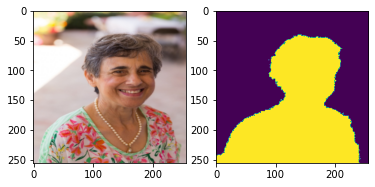

In [24]:
imgs_batch, annos_batch = next(iter(train_dataloader))
imgs_batch.shape, annos_batch.shape

img = imgs_batch[0].permute(1,2,0).numpy()
anno = annos_batch[0].numpy()

plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(anno)

## 搭建下采样子模型

In [25]:
class Downsample(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.conv_relu = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 
                                                            kernel_size=3, padding=1),
                                             torch.nn.ReLU(inplace=True),
                                             torch.nn.Conv2d(out_channels, out_channels, 
                                                             kernel_size=3, padding=1),
                                             torch.nn.ReLU(inplace=True))
        self.pool = torch.nn.MaxPool2d(kernel_size=2)
    def forward(self, x, is_pool=True):
        if is_pool:
            x = self.pool(x)
        x = self.conv_relu(x)
        return x

## 搭建上采样子模型

In [26]:
class Upsample(torch.nn.Module):
    def __init__(self, channels):
        super(Upsample, self).__init__()
        self.conv_relu = torch.nn.Sequential(torch.nn.Conv2d(2*channels, channels, 
                                                             kernel_size=3, padding=1),
                                             torch.nn.ReLU(inplace=True),
                                             torch.nn.Conv2d(channels, channels,  
                                                             kernel_size=3, padding=1),
                                             torch.nn.ReLU(inplace=True))
        self.upconv_relu = torch.nn.Sequential(torch.nn.ConvTranspose2d(in_channels=channels, 
                                                                        out_channels=channels//2, 
                                                                        kernel_size=3,
                                                                        stride=2,
                                                                        padding=1,
                                                                        output_padding=1),
                                               torch.nn.ReLU(inplace=True))
        
    def forward(self, x):
        x = self.conv_relu(x)
        x = self.upconv_relu(x)
        return x

## 编写UNet模型

In [28]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.down1 = Downsample(3, 64)
        self.down2 = Downsample(64, 128)
        self.down3 = Downsample(128, 256)
        self.down4 = Downsample(256, 512)
        self.down5 = Downsample(512, 1024)
        
        self.up = torch.nn.Sequential(torch.nn.ConvTranspose2d(1024, 512, kernel_size=3,
                                                               stride=2, padding=1, output_padding=1),
                                      torch.nn.ReLU(inplace=True))
        self.up1 = Upsample(512)
        self.up2 = Upsample(256)
        self.up3 = Upsample(128)
        
        self.conv_2 = Downsample(128, 64)
        self.last = torch.nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, x):
        x1 = self.down1(x, is_pool=False)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        
        x5 = self.up(x5)
        # dim=0-->batch, dim=1-->channel, dim=2-->width, dim=3-->height
        x5 = torch.cat([x4, x5], dim=1)           # 32*32*1024
        x5 = self.up1(x5)                         # 64*64*256
        x5 = torch.cat([x3, x5], dim=1)           # 64*64*512  
        x5 = self.up2(x5)                         # 128*128*128
        x5 = torch.cat([x2, x5], dim=1)           # 128*128*256
        x5 = self.up3(x5)                         # 256*256*64
        x5 = torch.cat([x1, x5], dim=1)           # 256*256*128
        
        x5 = self.conv_2(x5, is_pool=False)       # 256*256*64
        
        x5 = self.last(x5)                        # 256*256*3
        return x5

In [29]:
model = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device=device)

from torchsummary import summary
summary(model, input_size=((3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
        Downsample-5         [-1, 64, 224, 224]               0
         MaxPool2d-6         [-1, 64, 112, 112]               0
            Conv2d-7        [-1, 128, 112, 112]          73,856
              ReLU-8        [-1, 128, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]         147,584
             ReLU-10        [-1, 128, 112, 112]               0
       Downsample-11        [-1, 128, 112, 112]               0
        MaxPool2d-12          [-1, 128, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         295,168
             ReLU-14          [-1, 256,

## 模型训练

In [32]:
loss_fn = torch.nn.CrossEntropyLoss()
from torch.optim import lr_scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [33]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / (total*256*256)
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / (test_total*256*256)
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3))
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [34]:
epochs = 10

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dataloader,
                                                                 test_dataloader)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.073 accuracy: 0.709 test_loss：  0.065 test_accuracy: 0.773
epoch:  1 loss：  0.055 accuracy: 0.809 test_loss：  0.051 test_accuracy: 0.826
epoch:  2 loss：  0.045 accuracy: 0.844 test_loss：  0.044 test_accuracy: 0.85
epoch:  3 loss：  0.043 accuracy: 0.853 test_loss：  0.042 test_accuracy: 0.862
epoch:  4 loss：  0.04 accuracy: 0.866 test_loss：  0.04 test_accuracy: 0.864


## 保存模型

In [ ]:
PATH = 'unet_model.pth'
torch.save(model.state_dict(), PATH)

## 模型测试

In [ ]:
my_model = Net()
my_model.load_state_dict(torch.load(PATH))

num=3
image, mask = next(iter(test_dataloader))
pred_mask = my_model(image)

plt.figure(figsize=(10, 10))
for i in range(num):
    plt.subplot(num, 3, i*num+1)
    plt.imshow(image[i].permute(1,2,0).cpu().numpy())
    plt.subplot(num, 3, i*num+2)
    plt.imshow(mask[i].cpu().numpy())
    plt.subplot(num, 3, i*num+3)
    plt.imshow(torch.argmax(pred_mask[i].permute(1,2,0), axis=-1).detach().numpy())